In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        continue

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df_abide2 = pd.read_csv("./abide2_data.csv")
df_abide2.head()



,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX
0,28675,1,21.0,1
1,28676,1,21.0,1
2,28677,1,24.0,1
3,28678,1,24.0,2
4,28679,1,20.0,1


Image shape: (224, 224)


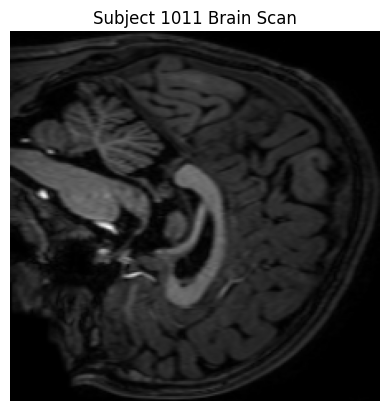

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

nii_path ="./abide2_preprocessed/29120/29120_.nii"
# nii_path = "/kaggle/input/abide-2d-complete/abide2_preprocessed/28675/28675_.nii"
img = nib.load(nii_path)
img_data = img.get_fdata()

print("Image shape:", img_data.shape)

if img_data.ndim == 3:
    slice_idx = img_data.shape[2] // 2
    plt.imshow(img_data[:, :, slice_idx], cmap='gray')
elif img_data.ndim == 2:
    plt.imshow(img_data, cmap='gray')
else:
    print("Unexpected image shape.")

plt.title("Subject 1011 Brain Scan")
plt.axis('off')
plt.show()



## Training Code

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split

# Parameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
DATA_DIR = "./abide2_preprocessed"
CSV_FILE = "./abide2_data.csv" 


df = pd.read_csv(CSV_FILE, dtype={'SUB_ID': str})

def load_nii_file(file_path):
    try:
        img = nib.load(file_path).get_fdata()
        if len(img.shape) != 2:
            print(f"Warning: {file_path} has unexpected shape {img.shape}")
            return None
        img = tf.image.resize(img[..., np.newaxis], IMG_SIZE).numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-10)  # Normalize
        # print(f"Loaded 1 image from {file_path}") 
        # ^ i find this annoying but its upto uncomment if theres errors
        return img
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

images = []
labels = []
for idx, row in df.iterrows():
    sub_id = row["SUB_ID"]
    label = row["DX_GROUP"] - 1  # Convert to 0 (TD) or 1 (ASD)
    nii_path = os.path.join(DATA_DIR, sub_id, f"{sub_id}_.nii")
    if os.path.exists(nii_path):
        img = load_nii_file(nii_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    else:
        print(f"File not found: {nii_path}")

images = np.array(images)
labels = np.array(labels)
print(f"Total images loaded: {len(images)}, Total labels: {len(labels)}")

if len(images) == 0 or len(labels) == 0:
    raise ValueError("No images or labels loaded. Check file paths, CSV, or .nii files.")

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
print(f"Training set: {len(X_train)} images, Validation set: {len(X_val)} images")

#simple CNN (u can try different models later on)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy', # BCE
              metrics=['accuracy'])

File not found: ./abide2_preprocessed\28682\28682_.nii
File not found: ./abide2_preprocessed\28817\28817_.nii
File not found: ./abide2_preprocessed\29305\29305_.nii
File not found: ./abide2_preprocessed\29327\29327_.nii
Total images loaded: 1110, Total labels: 1110
Training set: 888 images, Validation set: 222 images


c:\Users\ZAINAB\OneDrive - National University of Sciences & Technology\Autism_Project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=20,
                    validation_data=(X_val, y_val))

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.6430 - loss: 0.6361 - val_accuracy: 0.5631 - val_loss: 0.6662
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.6417 - loss: 0.6139 - val_accuracy: 0.5901 - val_loss: 0.6730
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 334ms/step - accuracy: 0.6948 - loss: 0.5937 - val_accuracy: 0.6171 - val_loss: 0.6649
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.7091 - loss: 0.5872 - val_accuracy: 0.6126 - val_loss: 0.6656
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.7020 - loss: 0.5718 - val_accuracy: 0.6171 - val_loss: 0.6817
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.7237 - loss: 0.5482 - val_accuracy: 0.6396 - val_loss: 0.6801
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 315ms/step - accuracy: 0.7264 - loss: 0.5467 - val_accuracy: 0.6351 - val_loss: 0.6892
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 0.7404 - loss: 0.4959 - val_accuracy: 

## Inference

In [10]:
import numpy as np
import tensorflow as tf
import nibabel as nib

IMG_SIZE = (128, 128)
NII_FILE = "./abide2_preprocessed/30177/30177_.nii"  #taking imgs from train

def load_nii_file(file_path):
    try:
        img = nib.load(file_path).get_fdata()
        if len(img.shape) != 2:
            raise ValueError(f"Expected 2D image, got shape {img.shape}")
        img = tf.image.resize(img[..., np.newaxis], IMG_SIZE).numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-10)  
        return img
    except Exception as e:
        raise ValueError(f"Error loading {file_path}: {str(e)}")

img = load_nii_file(NII_FILE)

prediction = model.predict(np.expand_dims(img, axis=0))[0][0]
if prediction >= 0.5:
    print(f"Prediction: ASD (Confidence: {prediction:.4f})")
else:
    print(f"Prediction: TD (Confidence: {1 - prediction:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Prediction: TD (Confidence: 1.0000)


In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix  # For calculating specificity
import numpy as np

def evaluate_model(y_true, y_pred, y_prob=None, model_name=""):
    """
    Calculates and prints common classification metrics.

    Args:
        y_true (array-like): Ground truth labels.
        y_pred (array-like): Predicted labels.
        y_prob (array-like, optional): Predicted probabilities for the positive class.
                                       Required for AUC-ROC. Defaults to None.
        model_name (str, optional): Name of the model being evaluated.
                                     Defaults to an empty string.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    if model_name:
        print(f"--- Performance Metrics for {model_name} ---")

    metrics = {}

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    metrics['Accuracy'] = accuracy
    print(f"Accuracy: {accuracy:.4f}")

    # F1-Score
    f1 = f1_score(y_true, y_pred)
    metrics['F1-Score'] = f1
    print(f"F1-Score: {f1:.4f}")

    # Sensitivity (Recall)
    sensitivity = recall_score(y_true, y_pred)
    metrics['Sensitivity'] = sensitivity
    print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")

    # Specificity
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'] = specificity
    print(f"Specificity (True Negative Rate): {specificity:.4f}")

    # AUC-ROC (Optional)
    if y_prob is not None:
        try:
            auc_roc = roc_auc_score(y_true, y_prob)
            metrics['AUC-ROC'] = auc_roc
            print(f"AUC-ROC: {auc_roc:.4f}")
        except ValueError:
            print("Warning: Cannot calculate AUC-ROC with only one class present in y_true.")
    elif 'AUC-ROC' in metrics:
        del metrics['AUC-ROC']  # Remove if y_prob is None

    return metrics

# Evaluate the model on the validation set
y_pred_val = model.predict(X_val)
y_pred_val_binary = (y_pred_val > 0.5).astype(int).flatten()

# If your model outputs probabilities for the positive class directly, use y_pred_val
# Otherwise, if it outputs a single binary prediction, y_pred_val is already suitable.
# For AUC-ROC, you need the probability scores (before binarization).

evaluation_metrics = evaluate_model(y_val, y_pred_val_binary, y_pred_val.flatten(), model_name="ABIDE-I CNN")
print("\nValidation Set Evaluation Metrics:", evaluation_metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
--- Performance Metrics for ABIDE-I CNN ---
Accuracy: 0.6126
F1-Score: 0.6504
Sensitivity (True Positive Rate): 0.6780
Specificity (True Negative Rate): 0.5385
AUC-ROC: 0.6474

Validation Set Evaluation Metrics: {'Accuracy': 0.6126126126126126, 'F1-Score': 0.6504065040650406, 'Sensitivity': 0.6779661016949152, 'Specificity': np.float64(0.5384615384615384), 'AUC-ROC': np.float64(0.6474087353324642)}
